# CO416 - Machine Learning for Imaging

# Tutorial 2 - Scikit Learn & Image Classification


## Regularisation 

Machine Learning models may overfit to your training data (as discussed in Lecture 2 from slide 35). To avoid overfitting we add to our loss function a regularisation term controlled by a weighting $\lambda$. 

In the lectures you learned about two elementary regularisers, the L1 and L2 regularisation also known as Lasso and Ridge penalty, respectively.



In [1]:
import numpy as np
import struct 
import gzip
import pandas as pd 
import sklearn
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition
import sklearn.pipeline# adjust settings to plot nice figures inline
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [3]:
# data directory
data_dir = '/home/adicatana/mli_tutorial_1/mnist'
import torchvision.datasets as dset

# train data
train_set = dset.MNIST(root=data_dir, train=True, download=False)
train_x_mnist = np.array(train_set.train_data)
train_y_mnist = np.array(train_set.train_labels)

# test data
test_set = dset.MNIST(root=data_dir, train=False, download=False)
test_x_mnist = np.array(test_set.test_data)
test_y_mnist = np.array(test_set.test_labels)

In [4]:
############################################################################
# Extract sample digits 
############################################################################

def sample_data_digits(data, labels, labels_to_select):
    # convert input 3d arrays to 2d arrays
    
    nsamples, nx, ny = data.shape
    
    data_vec = np.reshape(data,(nsamples,nx*ny))
   
    selected_indexes = np.isin(labels, labels_to_select)
    selected_data = data_vec[selected_indexes]
    selected_labels = labels[selected_indexes]
    
    
    # Convert images from gray to binary by thresholding intensity values
    selected_data = 1.0 * (selected_data >= 128)

    # convert labels to binary: digit_1=False, digit_2=True
    selected_labels = selected_labels==labels_to_select[1]
    # shuffle data
    shuffle_index = np.random.permutation(len(selected_labels))
    selected_data, selected_labels = selected_data[shuffle_index], selected_labels[shuffle_index]
     
    return selected_data, selected_labels




In [5]:
from sklearn.manifold.t_sne import TSNE
from sklearn.neighbors.classification import KNeighborsClassifier
def plot_decision_boundary(model,X,y):
    Y_pred=model.predict(X)
    X_Train_embedded = TSNE(n_components=2).fit_transform(X)
    # create meshgrid
    resolution = 100 # 100x100 background pixels
    X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
    X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
    xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

    # approximate Voronoi tesselation on resolution x resolution grid using 1-NN
    background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, Y_pred) 
    voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
    voronoiBackground = voronoiBackground.reshape((resolution, resolution))

    #plot
    plt.contourf(xx, yy, voronoiBackground)
    plt.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], c=y)
    plt.show()


## Using Regularisers 

We will first use a toy example to better understand the concept of regularisation. The dataset to be used here is the *'make moons'* one which can be directly used from sklearn

**TASK**
- Train a SGD classifier with `loss='log'` to implement a logistic regression. 
- Use all regularisations and evaluate the performance of your model.
- Does your model overfit less or more after reguralization ? 

As you saw regularization does not affect the performance when the feature space is small. In order then to augment our feature space we make polynomial combinations of the existing features.

- Using sklearns sklearn.preprocessing.PolynomialFeatures with different order polynomials we can create polynomial combinations of our features. 


None
normal 0.865
polynomial 0.86


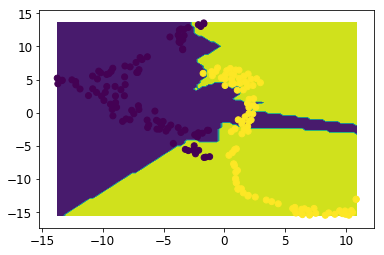

L1
normal 0.875
polynomial 0.86


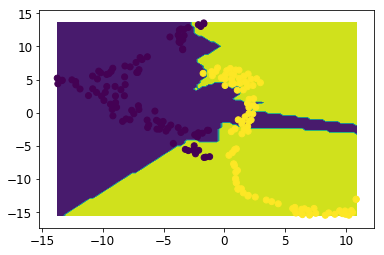

L2
normal 0.865
polynomial 0.97


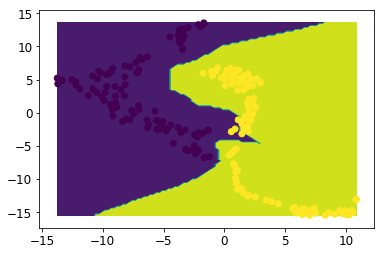

In [8]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

np.random.seed(42)

X, Y = make_moons(1000, noise=0.1)
#####################################################################
# Perform a train test split , use 20% of your dataset for testing.
#####################################################################
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
#####################################################################
# Perform a polynomial feature transform  use degree 10 to start and then explore different polynomial degrees
#####################################################################
pol_transform = sklearn.preprocessing.PolynomialFeatures(degree=10)
x_train_new = pol_transform.fit_transform(X_train)
x_test_new = pol_transform.fit_transform(X_test)
a=x_test_new
for pen in ['None', 'L1', 'L2']:
    np.random.seed(42)

    print(pen)
    #####################################################################
    # Set up a SGD Classifier for various penalties , train and evaluate it.
    #####################################################################
    model = SGDClassifier(loss='log', penalty=pen, alpha=0.002, tol=None)
    model.fit(X_train, y_train)
    scores = model.score(X_test, y_test)
    print('normal {}'.format(scores))
    # Predict the function value for the whole test set
    #     plot_decision_boundary(model,X_test,y_test)

    #####################################################################
    # Using the polynomial features, train and evaluate your classifer.
    #####################################################################
    model.fit(x_train_new, y_train)
    scores = model.score(x_test_new, y_test)

    print('polynomial {}'.format(scores))
    #####################################################################
    # Plot the decision boundary 
    #####################################################################
    plot_decision_boundary(model, x_test_new, y_test)



## Diving Deeper 

Now we will move back to the MNIST dataset. Extract from the dataset digits 0 and 8.

**TASK**

Below you will find the model solution for the logistic regression classifier as defined in Tutorial 1. 
- Modify this class to take one more argument that is the penalty and apply the penalty function to the loss. 
- Implement L1 and L2 regularisations not the elastic net.
- Use your model and comment on how regularisation alters the performance 

See the lecture notes at Lecture 2 slide 39-41 

In [10]:
###########################################################################
# Extract ones and eights digits from both training and testing data 
############################################################################
labels_to_select = [0,8]
selected_train_data, selected_train_labels = sample_data_digits(train_x_mnist,train_y_mnist,labels_to_select)
selected_test_data, selected_test_labels = sample_data_digits(test_x_mnist,test_y_mnist,labels_to_select)

In [11]:
from sklearn.base import BaseEstimator, ClassifierMixin
class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.05, num_iter=1000, add_bias=True, verbose=True,lambda_val=0.5,penalty='L1'):
        self.lr = lr
        self.lambda_val = lambda_val
        self.verbose = verbose
        self.num_iter = num_iter
        self.add_bias = add_bias
        self.penalty = penalty
        
    
    def __add_bias(self, X):
        bias = np.ones((X.shape[0], 1))
        return np.concatenate((bias, X), axis=1)
    

    ############################################################################
    #  compute the loss + ADD YOUR PENALTY HERE
    ############################################################################
    def __loss(self, h, y):
        ''' computes loss values '''
        y = np.array(y,dtype=float)
        if self.penalty=='None':
            reg=0
        elif self.penalty=='L1':
            reg=self.lambda_val * np.sum(np.linalg.norm(self.theta))
        elif self.penalty=='L2':
            reg=self.lambda_val * np.sum(self.theta**2)/2
            
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)+ reg ).mean()

    
    def fit(self, X, y):
        ''' 
        Optimise our model using gradient descent
        Arguments:
            X input features
            y labels from training data
            
        '''
        if self.add_bias:
            X = self.__add_bias(X)
        
        
        ############################################################################
        #initialise weights randomly with normal distribution N(0,1)
        ############################################################################
        self.theta = np.random.normal(0.0,0.01,X.shape[1])
        
        for i in range(self.num_iter):
            ############################################################################
            #  forward propagation
            ############################################################################
            z = X.dot(self.theta)
            h = 1.0 / (1.0 + np.exp(-z))
            ############################################################################
            #  backward propagation + ADD YOUR PENALTY HERE
            ############################################################################
            # update parameters
            if self.penalty=='None':
                self.theta -= self.lr * ( np.dot(X.T, (h - y))) / y.size

            elif self.penalty=='L1':
                self.theta -= self.lr * ( np.dot(X.T, (h - y))+self.lambda_val*np.sign(self.theta)) / y.size

            elif self.penalty=='L2':
                self.theta -= self.lr * ( np.dot(X.T, (h - y))+self.lambda_val*self.theta) / y.size

       
            ############################################################################
            # print loss
            ############################################################################
            if(self.verbose == True and i % 50 == 0):
                h = 1.0 / (1.0 + np.exp(-X.dot(self.theta)))
                print('loss: {} \t'.format(self.__loss(h, y)))
    
    def predict_probs(self,X):
        ''' returns output probabilities
        '''
        ############################################################################
        # forward propagation
        ############################################################################
        if self.add_bias:
            X = self.__add_bias(X)
        z = X.dot(self.theta)
        return 1.0 / (1.0 + np.exp(-z))

    def predict(self, X, threshold=0.5):
        ''' returns output classes
        '''
        return self.predict_probs(X) >= threshold
    
    def score(self, X,Y):
        '''
            Returns accuracy of model
        '''
        preds = self.predict(X)
        accuracy = (preds == Y).mean()
        return accuracy
    

### Deploying Regressor with regularisation

In order to see the full effect of the regularisation we look into a scenario where the classifier clearly overfits. We will only use a small portion of the MNIST dataset, with 75 data points to begin with and then experiment with other values.

**TASK**

- Train your logistic regressor with 75 training datapoints, learning rate=1e-3 and 10,000 iteration and all possible penalties
- Evaluate the performance of your model, using model.score(X,Y)
- Use the weight plotting function from Tutorial 1 and comment on how reguralization affects them (Hint see slide 41 from lecture 2) 

None with lambda 0.7 training: 1.0
None with lambda 0.7: 0.9882292732855681


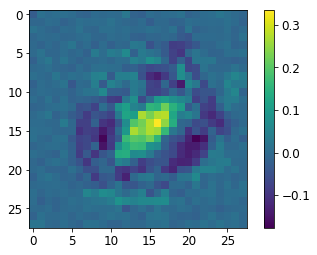

L1 with lambda 0.7 training: 1.0
L1 with lambda 0.7: 0.9902763561924258


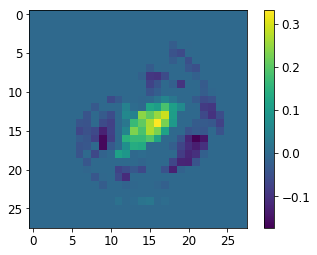

L2 with lambda 0.7 training: 1.0
L2 with lambda 0.7: 0.9866939611054247


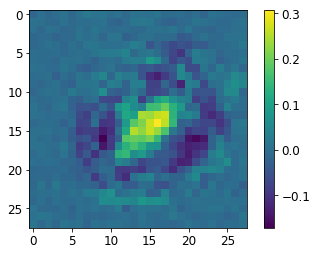

In [12]:
#########################################################################
# Q: train our model using raw pixels , train for all penalties and for various lambda values
#########################################################################
for pen in ['None','L1','L2']:
    for lam_val in [0.7]:
        model = LogisticRegression(lr=1e-3, num_iter=10000,penalty=pen,lambda_val=lam_val,verbose=False)
        model.fit(selected_train_data[0:75,:], selected_train_labels[0:75])

        #########################################################################
        # Q: Evaluate the trained model - compute train and test accuracies
        # You should get accuracies around 98-99%
        #########################################################################
        logistic_train_error=model.score(selected_train_data[0:75,:],selected_train_labels[0:75])
        print('{} with lambda {} training: {}'.format(pen,lam_val,logistic_train_error))


        
        test_preds = model.predict(selected_test_data)
        logistic_test_error = (test_preds == selected_test_labels).mean()
        print('{} with lambda {}: {}'.format(pen,lam_val,logistic_test_error))

        #########################################################################
        # Q: draw trained model params (weights) as an image of size (28x28)
        #########################################################################
        plt.imshow(model.theta[:-1].reshape(28,28))
        plt.colorbar()
        plt.show()

### Regularisation using sklearn
Now that we know how to implement logistic regression with L1 and L2 regularisation on numpy lets use an industry standard version - sklearn 

**TASK**

Use sklearns SGD classifier with the `loss='log'` to perform logistic regression, you can change the penalty function by changing the `penalty` argument 
- Use all 10 classes
- Do you get different performance ? 
- Why is there a difference ? 

In [13]:
############################################################################
############################################################################
# reshape to (N,728) this is number of samples N and the nuber of features 28x28=728
x_train=np.reshape(train_x_mnist,(train_x_mnist.shape[0],train_x_mnist.shape[1]*train_x_mnist.shape[2]))
x_test=np.reshape(test_x_mnist,(test_x_mnist.shape[0],test_x_mnist.shape[1]*test_x_mnist.shape[2]))

In [15]:
############################################################################
############################################################################
# No Regularisation 
############################################################################
clf= SGDClassifier(loss='log',penalty='none',learning_rate='constant',eta0=1e-3,max_iter=10)
clf.fit(x_train, train_y_mnist)
print ('no regularisation = {}'.format(clf.score(x_test,test_y_mnist)))
############################################################################
# L1 Reguralization 
############################################################################
clf= SGDClassifier(loss='log',penalty='l1',alpha=0.5,learning_rate='constant',eta0=1e-3,max_iter=10)
clf.fit(x_train, train_y_mnist)
print ('L1 regularisation = {}'.format(clf.score(x_test,test_y_mnist)))
############################################################################
# L2 Reguralization 
############################################################################
clf= SGDClassifier(loss='log',penalty='l2',alpha=0.5,learning_rate='constant',eta0=1e-3,max_iter=10)
clf.fit(x_train, train_y_mnist)
print ('L2 regularisation = {}'.format(clf.score(x_test,test_y_mnist)))

no regularisation = 0.8831
L1 regularisation = 0.751
L2 regularisation = 0.7716


## Validation 

As you have seen so far the performance of your models heavily depend on the values of the hyperparameters you choose. As we do not know a priori how these would affect the test accuracy we reserve a portion of our training data to use as a validation set. Using the test set is forbidden as this constitutes data-snooping and it makes our experiments null, and we would find unrealistic performance in the real world. 

**TASK**
- Using sklearns SGD classifier with log loss alter the validation portion.
- Build your own validation scheme. 
   - Use the train-val-test split function and also determine a set of possible values for your hyperparameters (use different learning rates and different $\lambda$ values for the regulariser (in sklearn the name the parameter to be $\alpha$).
   - Iterate though your possible values and evaluate the performance of your algorithm with the validation set 
   - Determine the best hyperparameters based on the performance on the validation set
   - Execute a complete training and evaluate the models performance on the testing set
   

In [ ]:
from sklearn.model_selection import train_test_split
############################################################################
# Split into train and val 
############################################################################
X_train, X_val, y_train, y_val = train_test_split(x_train, train_y_mnist, test_size=0.10, random_state=42)
#Initialize best values
best_acc=(0,0,0) 
############################################################################
# Iterate over selected values
############################################################################
for lr in [1e-2,1e-3,1e-6]:
    for al in [0.5,0.1,0.01]:
        clf= SGDClassifier(loss='log',penalty='l1',alpha=al,learning_rate='constant',eta0=lr,max_iter=10)
        clf.fit(X_train, y_train)
        acc=clf.score(X_val,y_val)
        print ('L1 lambda = {}, learning rate = {}, accuracy = {}'.format(al,lr,acc))
        if best_acc[2]<acc:
            best_acc=(lr,al,acc)
 # print best hyperparameters and accuracy   
print(best_acc)

### Bonus 
- Implement an Elastic Net and then compare it with sklearns implementation. Redo all the above tests with this.